In [0]:
#Instalamos geopandas
pip install geopandas

#Instalamos mapclassify
pip install mapclassify

In [14]:
#Librerías varias
import os
import datetime
import pandas as pd
from datetime import date
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/COVID-19 Chile (Coronavirus)/Database (CSV)') #Carpeta donde tenemos guardados los datasets (csv)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Cargamos el primer dataset
El primer dataset contiene:
* Número total de contagiados con COVID-19 a la fecha
* Número de nuevos contagiados
* Número de recuperados a la fecha
* Número de fallecidos a la fecha


In [15]:
fq = pd.read_csv('Resumen_COVID-19_Chile_.csv')
fq

,recuperados a nivel nacional,Casos_fallecidos,Casos_totales_nuevos,Casos_totales_dia,Fecha
0,0,0,1,1,2020-03-03
1,0,0,3,2,2020-03-04
2,0,0,4,1,2020-03-05
3,0,0,5,1,2020-03-06
4,0,0,7,2,2020-03-07
5,0,0,10,3,2020-03-08
6,0,0,13,3,2020-03-09
7,0,0,17,6,2020-03-10
8,0,0,23,5,2020-03-11
9,0,0,33,11,2020-03-12


#Análisis de los datos

Este primer grafico nos muestra los casos de personas que tienen el COVID-19 acumulados en tiempo.

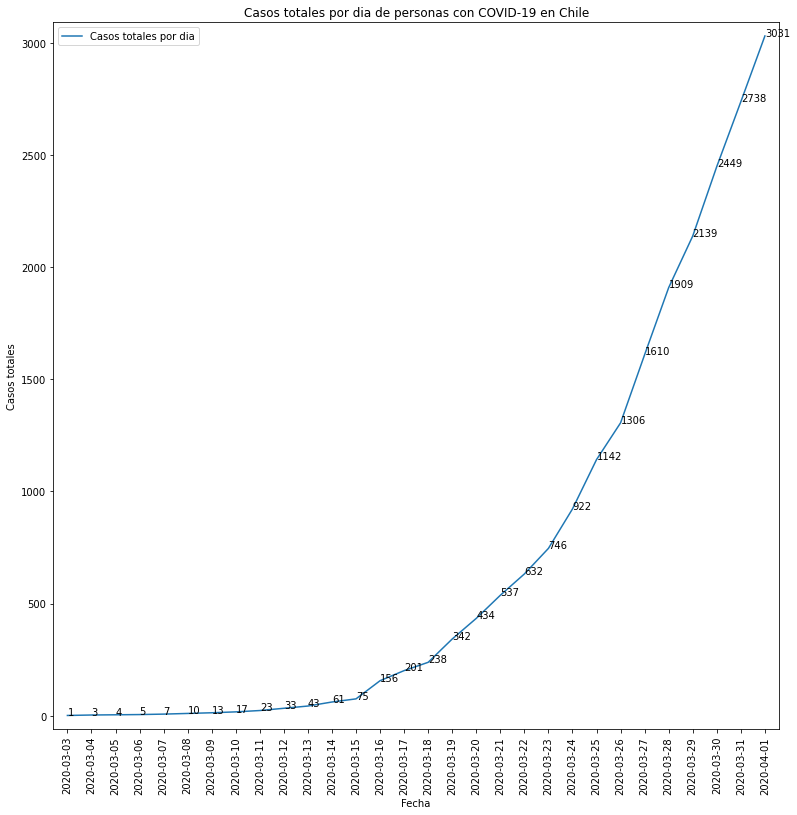

In [16]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize']=(13,13)

ay = fq.plot('Fecha','Casos_totales_nuevos',label='Casos totales por dia')
plt.title("Casos totales por dia de personas con COVID-19 en Chile")
plt.xlabel("Fecha")
plt.ylabel("Casos totales")
mapeado = range(len(fq.Casos_totales_nuevos))
plt.xticks(mapeado,fq.Fecha,rotation='vertical')
plt.margins(0.02)

for i, v in enumerate(fq['Casos_totales_nuevos']):
  ay.annotate(v, xy=(i, v))
  
plt.show()

Este grafico muestra casos nuevos de personas infectadas, los recuperados y fallecidos por día.

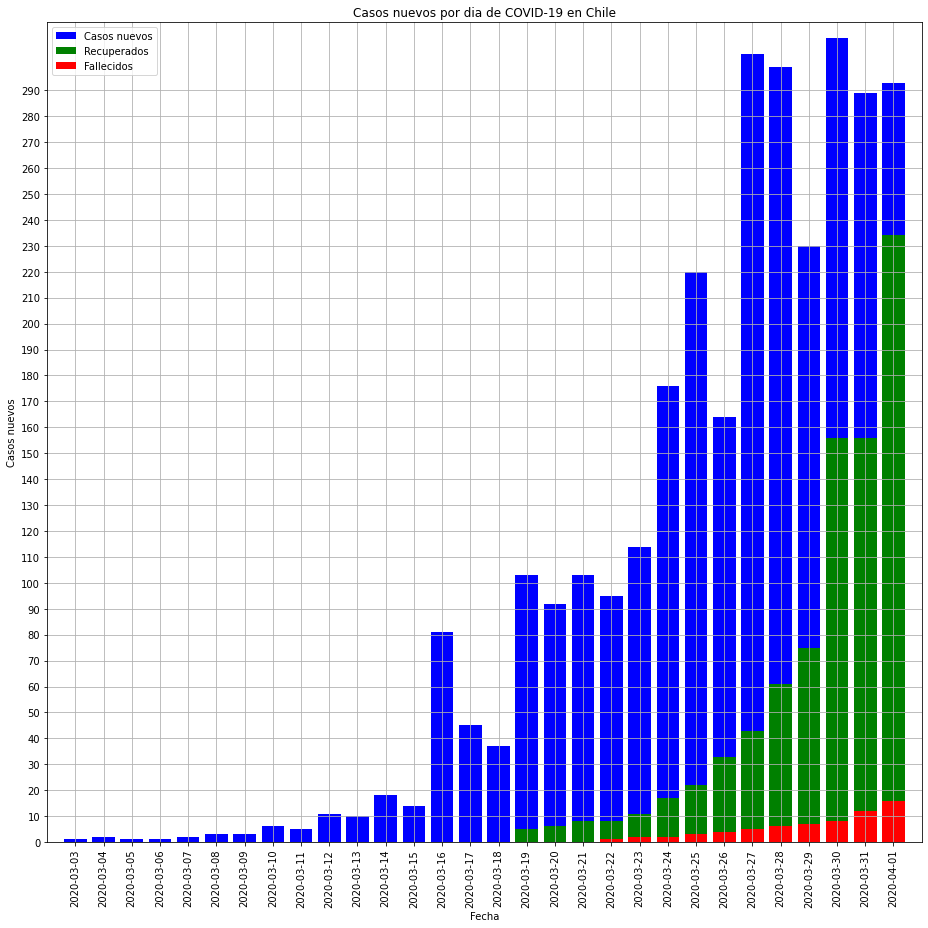

In [17]:
import numpy as np

fech = fq['Fecha']
plt.bar(fech,fq.Casos_totales_dia,color='blue',label = 'Casos nuevos')
plt.bar(fech,fq['recuperados a nivel nacional'], color = 'green',label ='Recuperados')
plt.bar(fech,fq.Casos_fallecidos, color = 'red',label = 'Fallecidos')


plt.title("Casos nuevos por dia de COVID-19 en Chile")
plt.xlabel("Fecha")
plt.ylabel("Casos nuevos")
mapeado2 = range(len(fq.Casos_totales_dia))
plt.xticks(mapeado2,fq.Fecha,rotation='vertical')
plt.yticks(np.arange(0,300,step=10))
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.grid(True)
plt.margins(0.02)
plt.show()


#Cargamos el segundo dataset
El segundo dataset contiene:
* Número casos nuevos
* Número casos totales a la fecha
* Número de fallecidos

y todos estos ordenados por región




In [18]:
df = pd.read_csv('Casos_COVID-19_Chile_'+str(date.today())+'.csv')
df.iloc[6:7,2:3]*=1000 #Esta fila nos da problas porque el 1000 lo interpreta como 1.0
df.style.background_gradient(cmap='Reds')

,Región,Casos nuevos,Casos totales,% Casos totales**,Fallecidos
0,Arica y Parinacota,0,6.000000,0 %,0
1,Tarapacá,2,10.000000,0 %,0
2,Antofagasta,4,39.000000,1 %,0
3,Atacama,1,3.000000,0 %,0
4,Coquimbo,2,30.000000,1 %,0
5,Valparaíso,21,136.000000,4 %,1
6,Metropolitana,101,1521.000000,50 %,5
7,O’Higgins,3,26.000000,1 %,0
8,Maule,9,71.000000,2 %,1
9,Ñuble,14,259.000000,9 %,0


#Análisis de los datos del segundo dataset
En este grafico se muestra los nuevos casos de COVID-19 del dia actual por region.


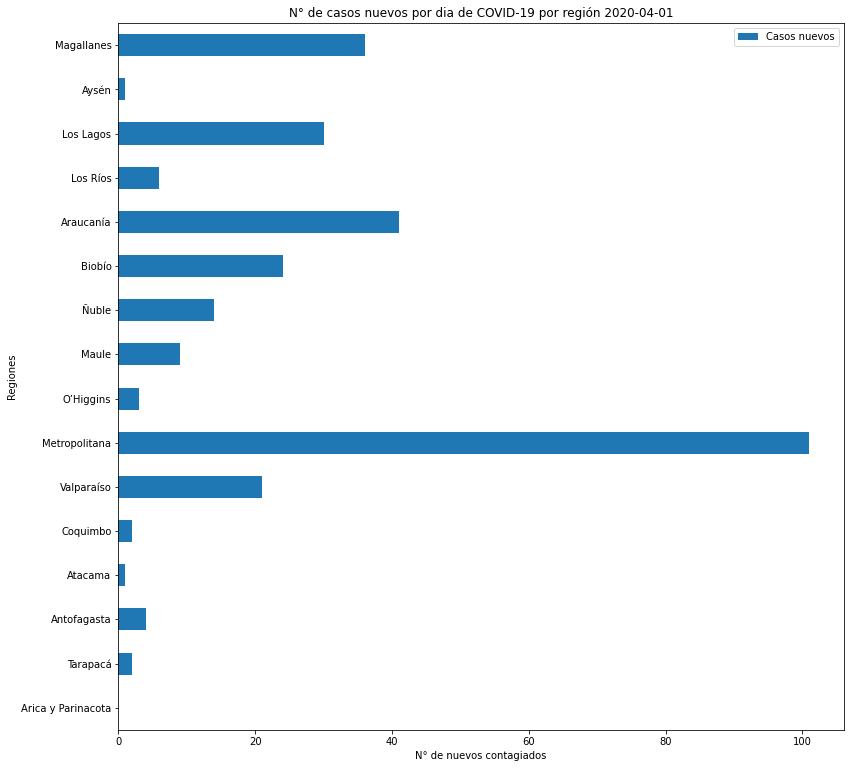

In [19]:
df.plot.barh('Región','Casos nuevos')
plt.title("N° de casos nuevos por dia de COVID-19 por región "+str(date.today()))
plt.xlabel('N° de nuevos contagiados')
plt.ylabel('Regiones')
plt.show()

Cargamos el archivo Geojson que contiene el mapa de chile.

In [20]:
import geopandas as gpd

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/COVID-19 Chile (Coronavirus)/Map')

map_data = gpd.read_file('Mapa_Chile_Regiones.geojson')
map_data.head()

mapa = map_data.iloc[:,1:2]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


En este grafico se muestra la concentración de infectados por región.

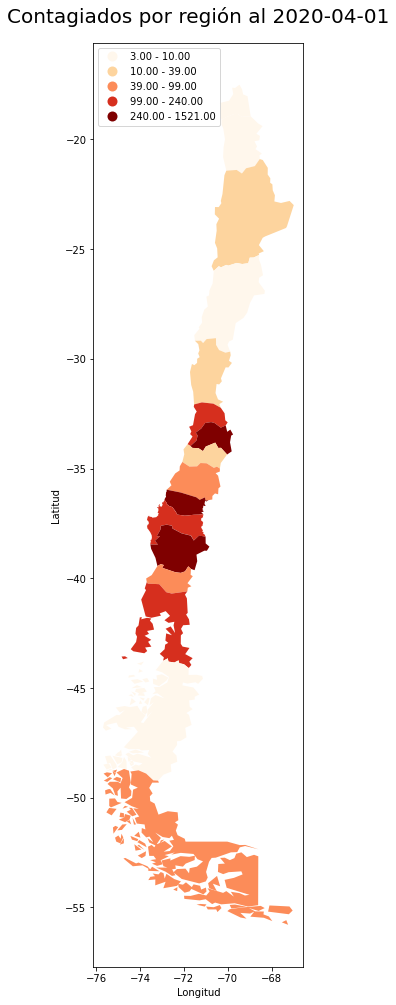

In [44]:
fig, ax = plt.subplots(figsize=(15, 17))

ax.set_title('Contagiados por región al '+str(date.today()), 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#000000'})

ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

casosxregion = df.iloc[:16,2:3]

map_data = map_data.assign(casos= casosxregion)
map_data.plot(column='casos', cmap='OrRd', ax=ax, legend=True, cax=cax, zorder=5,scheme='quantiles',legend_kwds={'loc': 'upper left'})

En este se muestra los casos totales por número de día.

Lo que hacemos aquí es una regresión polinomial para luego poder predecir los casos totales en un día X. 


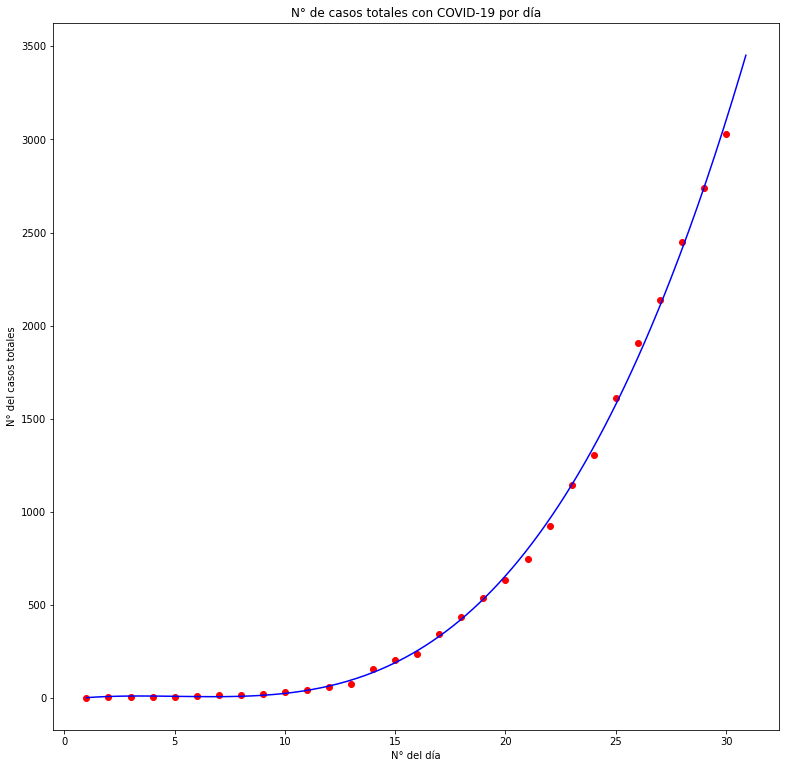

In [22]:
dias = np.arange(1,31)
X = dias.reshape(len(dias),1)
y = fq.iloc[:,2:3]

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

poly_regression = PolynomialFeatures(degree=3)
X_poly_regression = poly_regression.fit_transform(X)

lin_regression_2 = LinearRegression()
lin_regression_2.fit(X_poly_regression,y)

X_grid = np.arange(1,31,0.1)
X_grid = X_grid.reshape(len(X_grid),1)
plt.scatter(X,y,color='red')
plt.plot(X_grid,lin_regression_2.predict(poly_regression.fit_transform(X_grid)),color='blue')
plt.title('N° de casos totales con COVID-19 por día')
plt.xlabel('N° del día')
plt.ylabel('N° del casos totales')
plt.show()

Aquí hacemos una predicción para los próximos 4 días.

In [23]:

for i in range(29,32):
  prediccion = int(lin_regression_2.predict(poly_regression.fit_transform([[i]])))
  print('Dia '+str(i)+': '+str(prediccion)+' infectados aprox.')

Dia 29: 2740 infectados aprox.
Dia 30: 3101 infectados aprox.
Dia 31: 3493 infectados aprox.
